# Import libraries

In [34]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load event data 

In [35]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))

# Specifiy the volumes, I use 8, 13, 17 (see trackML kaggle comp)

In [36]:
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]

# Plot some ground truth tracks

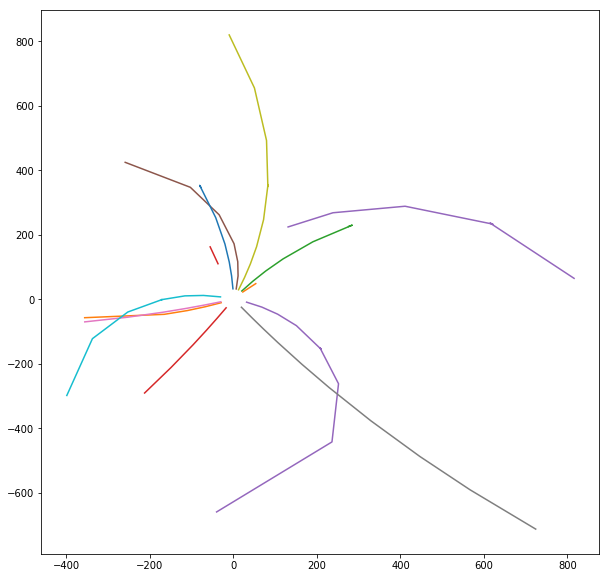

In [37]:
plt.figure(figsize=(10,10))
ax = plt.axes()
# Separate the tracks
tracks = selected_truth.particle_id.unique()[1::500]
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    ax.plot(t.tx, t.ty)

plt.show()

# Perform conformal mapping on the truth tracks

In [38]:
def conformal_map(zipped_x_y):
    conformal_x = []
    conformal_y = []
    for i, obj in enumerate(zipped_x_y):
        x = obj[0]
        y = obj[1]
        denom = x*x + y*y
        conformal_x.append(x / denom)
        conformal_y.append(y / denom)
    return conformal_x, conformal_y

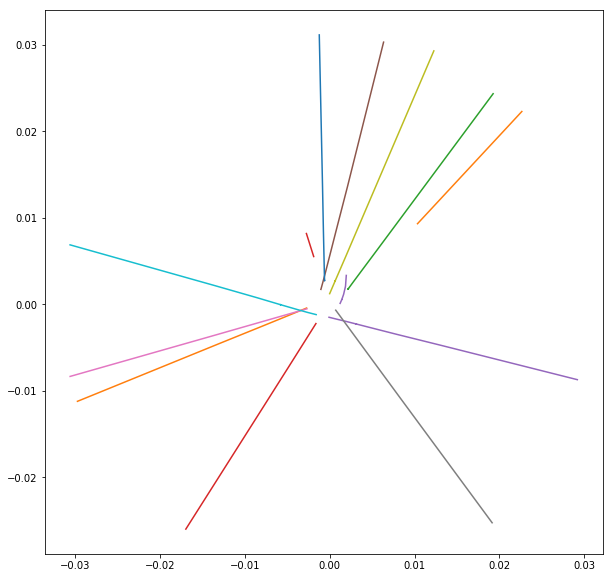

In [39]:
plt.figure(figsize=(10,10))
ax = plt.axes()
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    conformal_tx, conformal_ty = conformal_map(zip(t.tx, t.ty))
    ax.plot(conformal_tx, conformal_ty)

plt.show()

# We only see the volumes (8, 13, 17)

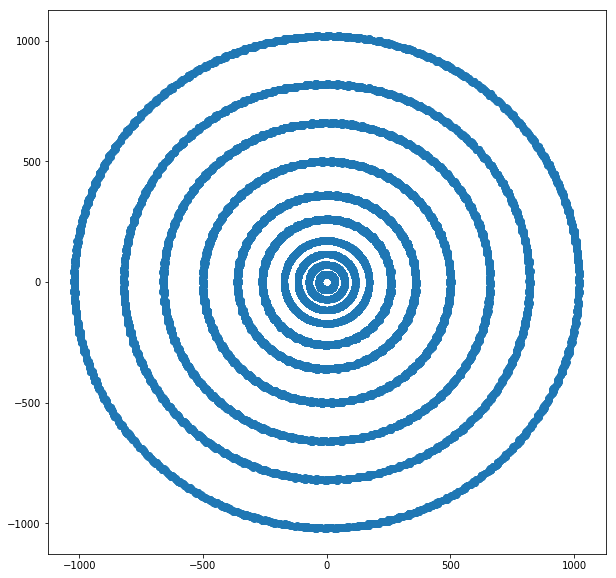

In [40]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
plt.show()

## perform a conformal mapping to see how it looks

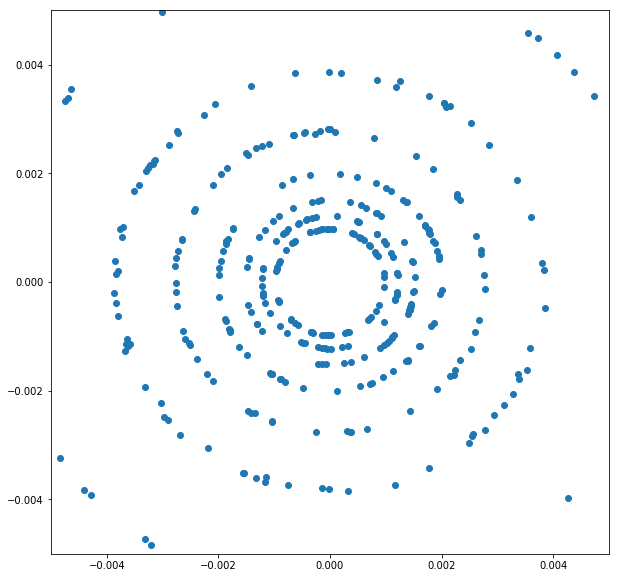

In [41]:
plt.figure(figsize=(10,10))
ax = plt.axes()

# dont show all
N = len(selected_hits.x)
booleanArr = np.random.rand(N) < 0.01
conformal_x, conformal_y = conformal_map(zip(selected_hits.x, selected_hits.y))
conformal_x = np.array(conformal_x)
conformal_y = np.array(conformal_y)
ax.plot(conformal_x[booleanArr], conformal_y[booleanArr], 'o')
res = 0.005
ax.set_xlim(-res, res)
ax.set_ylim(-res, res)
plt.show()

# Hard to see anything, but we know it works 

# Let us try some Line Hough Transformation

In [42]:
from hough import *

## Lets select one track

In [11]:
one_track = selected_truth.particle_id.unique()[200]
print("particle_id: %d" % track)

particle_id: 445867358242742274


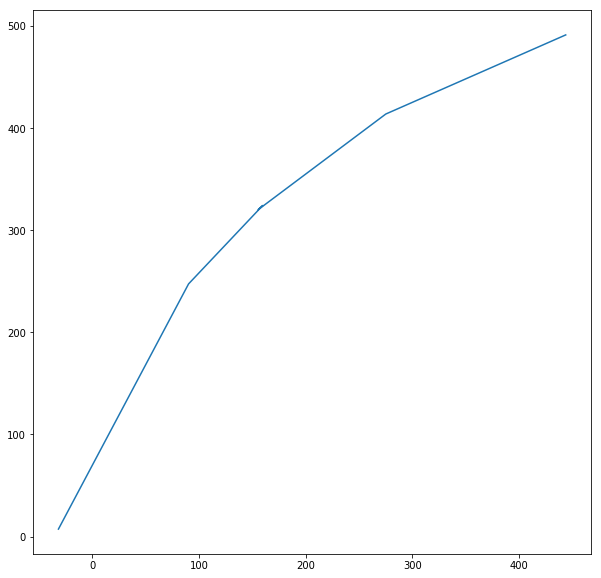

In [12]:
plt.figure(figsize=(10,10))
ax = plt.axes()
# Separate the tracks
one_t = selected_truth[selected_truth.particle_id == one_track]
ax.plot(one_t.tx, one_t.ty)
plt.show()

# Perform conformal mapping on above curve

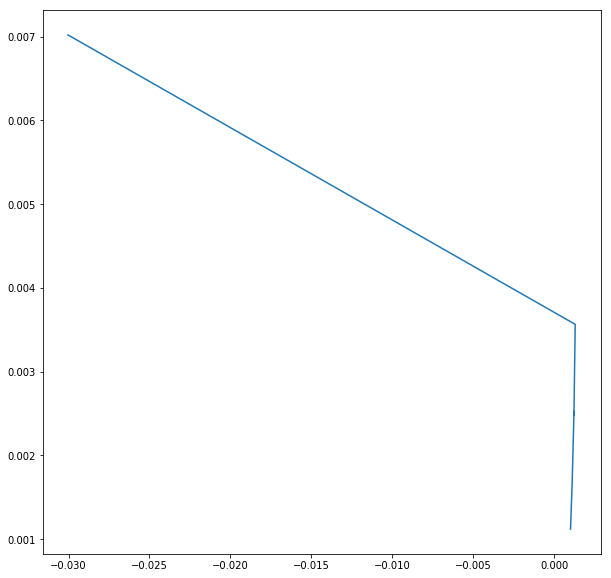

In [13]:
one_conformal_x, one_conformal_y = conformal_map(zip(one_t.tx, one_t.ty))

plt.figure(figsize=(10,10))
ax = plt.axes()
# Separate the tracks
ax.plot(one_conformal_x, one_conformal_y)
plt.show()

## First we need the basics, let us try and sample some points

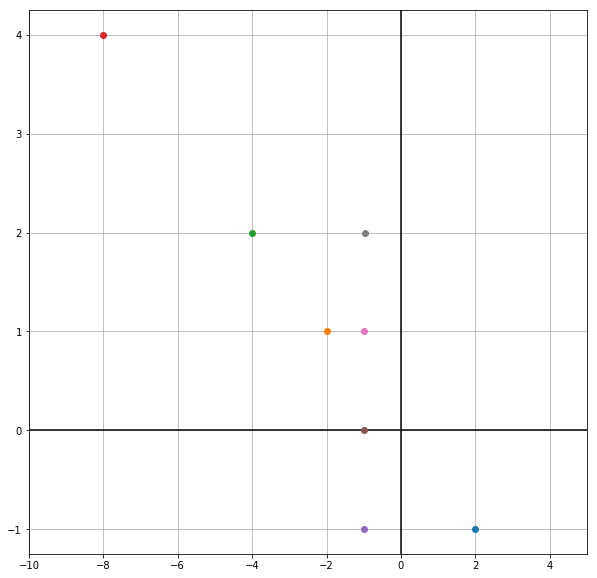

In [15]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_xlim(-10, 5)
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
# This is the point to focus on

points = np.array([[2, -1], [-2, 1], [-4, 2], [-8, 4], [-1, -1], [-0.99, 0], [-.98, 1], [-.97, 2]])
for p in points:
    ax.plot([p[0]], [p[1]], 'o')
plt.show()

In [54]:
maxRhos = np.array([])
maxThetas = np.array([])
threshhold = 3#np.max(accumulator)
for i in range(len(accumulator)):
    for j in range(len(accumulator[i])):
        if accumulator[i, j] >= threshhold:
            rhoRange = maxRho - minRho
            rho = ((i - (nrBinsRho / 2)) * rhoRange) / nrBinsRho
            maxRhos = np.append(maxRhos, rho)
            maxThetas = np.append(maxThetas, thetas[j])
print(maxRhos)
print(maxThetas)

[-0.03180731 -0.03180731 -0.03180731 ...  0.03145389  0.03145389
  0.03145389]
[1.00000000e-05 1.57967973e-02 3.15835945e-02 ... 3.11000906e+00
 3.12579586e+00 3.14158265e+00]


## Calculate the lines by using the rho and theta values that indicated on line in hough space

In [55]:
import math
y_approxes = []
for i in range(len(maxRhos)):
    y_approx = []
    for x_approx in range(-10,5):
        y_approx.append(-(x_approx * math.cos(maxThetas[i]) - maxRhos[i]) / (math.sin(maxThetas[i])));
    if len(y_approx) > 0:
        y_approxes.append(y_approx)
y_approxes = np.array(y_approxes)
#print(np.unravel_index(np.argmax(y_approxes), y_approxes.shape))
#print(y_approxes[2])

KeyboardInterrupt: 

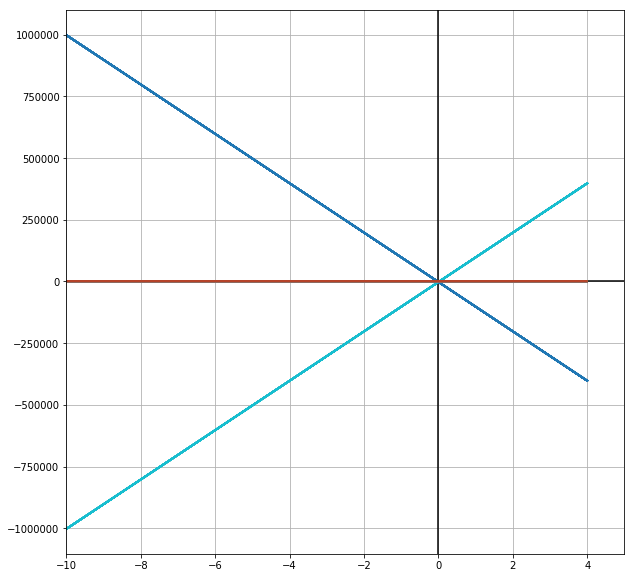

In [56]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_xlim(-10, 5)
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
# This is the point to focus on

for y_approx in y_approxes:
    ax.plot(range(-10, 5), y_approx)

for p in points:
    ax.plot([p[0]], [p[1]], 'o')
plt.show()

## Try with the hitpoints

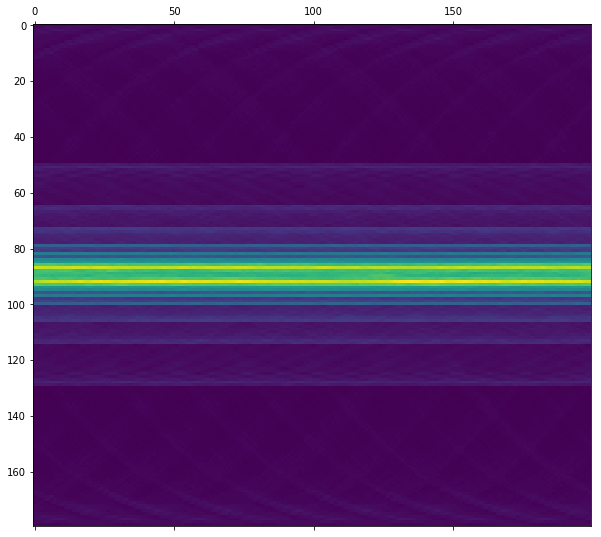

In [104]:
conformal_x, conformal_y = conformal_map(zip(selected_hits.x, selected_hits.y))
conformal_points = np.dstack((conformal_x, conformal_y))[0]

from math import pi
maxRho = max([np.linalg.norm(p) for p in conformal_points])
minRho = -maxRho
minTheta = -pi + 10**-5
maxTheta = pi - 10**-5

accumulator, maxRho, minRho, nrBinsRho, nrBinsTheta, thetas = createHoughSpace(conformal_points, minRho, maxRho, minTheta, maxTheta, 180, 200)

plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.matshow(accumulator)
plt.show()

In [135]:
maxRhos = np.array([])
maxThetas = np.array([])
threshhold = np.max(accumulator) - 500
for i in range(len(accumulator)):
    for j in range(len(accumulator[i])):
        if accumulator[i, j] >= threshhold:
            rhoRange = maxRho - minRho
            rho = ((i - (nrBinsRho / 2)) * rhoRange) / nrBinsRho
            maxRhos = np.append(maxRhos, rho)
            maxThetas = np.append(maxThetas, thetas[j])
print(maxRhos.shape)
print(maxThetas.shape)

(2250,)
(2250,)


In [136]:
visualizeHoughSpace3D(accumulator, minRho, maxRho, minTheta, maxTheta, nrBinsRho, nrBinsTheta)

NameError: name 'visualizeHoughSpace3D' is not defined

In [70]:
import math
lim = 1000 + 100
y_approxes = []
for i in range(len(maxRhos)):
    y_approx = []
    for x_approx in range(-lim,lim):
        if math.sin(maxThetas[i]) != 0:
            y_approx.append(-(x_approx * math.cos(maxThetas[i]) - maxRhos[i]) / (math.sin(maxThetas[i])));
    if len(y_approx) > 0:
        y_approxes.append(y_approx)
y_approxes = np.array(y_approxes)

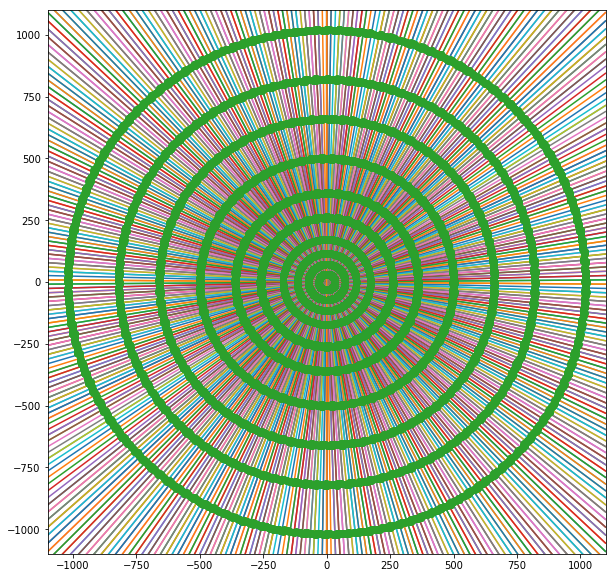

In [71]:
plt.figure(figsize=(10,10))
ax = plt.axes()
# This is the point to focus on
lim = 1000 + 100
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
for y_approx in y_approxes:
    ax.plot(range(-lim, lim), y_approx)
ax.plot(selected_hits.x, selected_hits.y, 'o')
plt.show()

In [ ]:
selected_truth.head()

## Try with the truth hit points (some tracks)

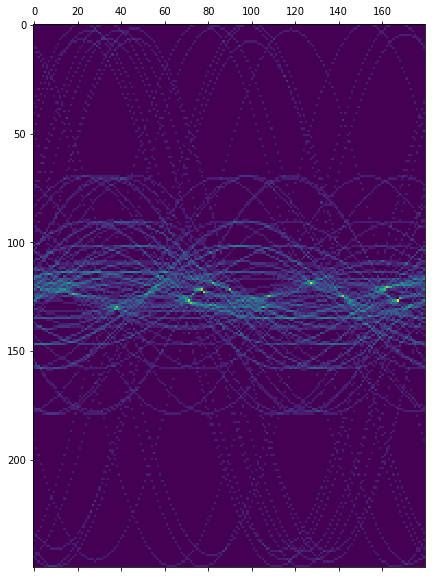

In [43]:
# Chose every 500th track
tracks = selected_truth.particle_id.unique()[1::500]
allTrackPoints = np.empty((0, 2))
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    ctx, cty = conformal_map(zip(t.tx, t.ty))
    ct = np.dstack([ctx, cty])[0]
    
    allTrackPoints = np.append(allTrackPoints, ct, axis=0)

allTrackPoints = np.vstack([allTrackPoints, np.array([0, 0])])

from math import pi
maxRho = max([np.linalg.norm(p) for p in allTrackPoints])
minRho = -maxRho
minTheta = -pi + 10**-5
maxTheta = pi - 10**-5

accumulator, maxRho, minRho, nrBinsRho, nrBinsTheta, thetas = createHoughSpace(allTrackPoints, minRho, maxRho, minTheta, maxTheta, 250, 180)
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.matshow(accumulator)
plt.show()

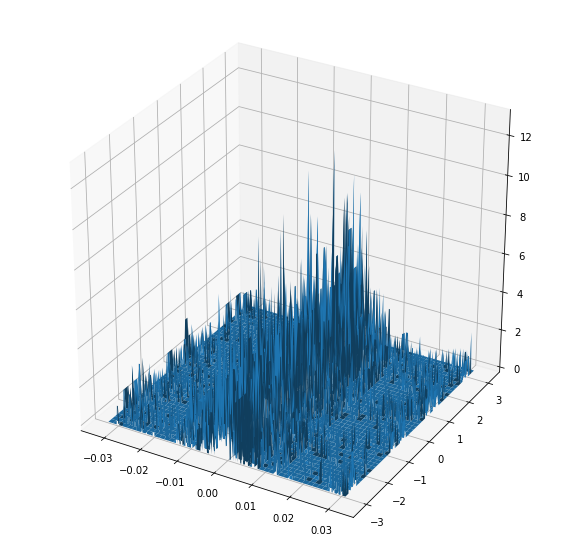

[(114, 60), (115, 7), (119, 16), (119, 82), (119, 127), (121, 162), (122, 90), (124, 18), (125, 108), (125, 142), (126, 101), (127, 71), (127, 167), (130, 38), (130, 105), (130, 172)]


In [44]:
visualizeHoughSpace3D(accumulator, minRho, maxRho, minTheta, maxTheta, nrBinsRho, nrBinsTheta)
threshhold = 8
maxPoints = findMaxValues(accumulator, nrBinsRho, nrBinsTheta, threshhold)
print(maxPoints)
maxIndex = np.unravel_index(np.argmax(accumulator), accumulator.shape)
nMax = n_max(accumulator, 20)
#print(nMax)

In [45]:
maxRhos = np.array([])
maxThetas = np.array([])
maxThreshhold = np.max(accumulator)
threshholdMes = [0 for _ in range(int(np.ceil(maxThreshhold)) + 1)]

for i in range(len(accumulator)):
    for j in range(len(accumulator[i])):
        threshholdMes[int(accumulator[i, j])] += 1
        
print(threshholdMes)
threshhold = 12

#for i in range(len(accumulator)):
#    for j in range(len(accumulator[i])):
#        if accumulator[i, j] >= threshhold:
#for n in nMax:
#    i = n[1][0]
#    j = n[1][1]
for p in maxPoints:
    i = p[0]
    rhoRange = maxRho - minRho
    rho = ((i - (nrBinsRho / 2)) * rhoRange) / nrBinsRho
    maxRhos = np.append(maxRhos, rho)
    maxThetas = np.append(maxThetas, thetas[p[1]])
print(maxRhos)

[34198, 6579, 2251, 1024, 525, 235, 106, 42, 21, 7, 4, 6, 1, 1]
[-0.00279904 -0.00254458 -0.00152675 -0.00152675 -0.00152675 -0.00101783
 -0.00076337 -0.00025446  0.          0.          0.00025446  0.00050892
  0.00050892  0.00127229  0.00127229  0.00127229]


In [46]:
import math
lim = 5
y_approxes = []
for i in range(len(maxRhos)):
    y_approx = []
    for x_approx in range(-lim,lim):
        if math.sin(maxThetas[i]) != 0:
            y_approx.append(-(x_approx * math.cos(maxThetas[i]) - maxRhos[i]) / (math.sin(maxThetas[i])));
    if len(y_approx) > 0:
        y_approxes.append(y_approx)
y_approxes = np.array(y_approxes)

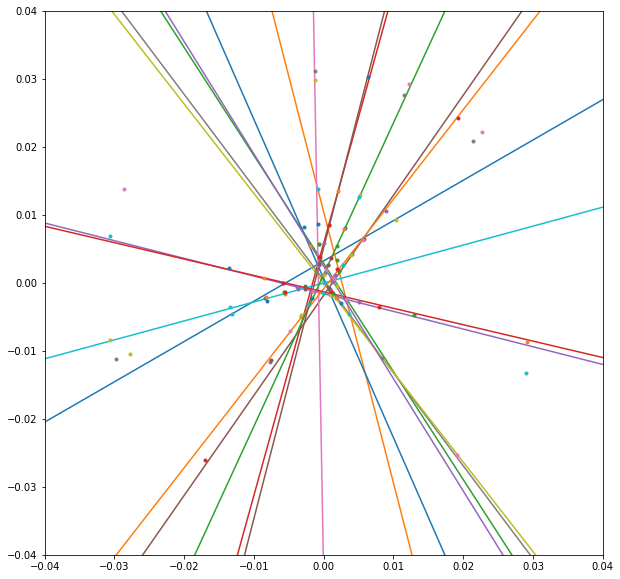

In [47]:
plt.figure(figsize=(10,10))
ax = plt.axes()
# This is the point to focus on
lim = .04
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
for y_approx in y_approxes:
    ax.plot(range(-5, 5), y_approx)
#for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    #if track == 0:
    #    continue
    #t = selected_truth[selected_truth.particle_id == track]
    #conformal_tx, conformal_ty = conformal_map(zip(t.tx, t.ty))
    #ax.plot(conformal_tx, conformal_ty, '.')
for p in allTrackPoints:
    ax.plot(p[0], p[1], '.')
plt.show()

## Perform the inverted mapping - back to lines

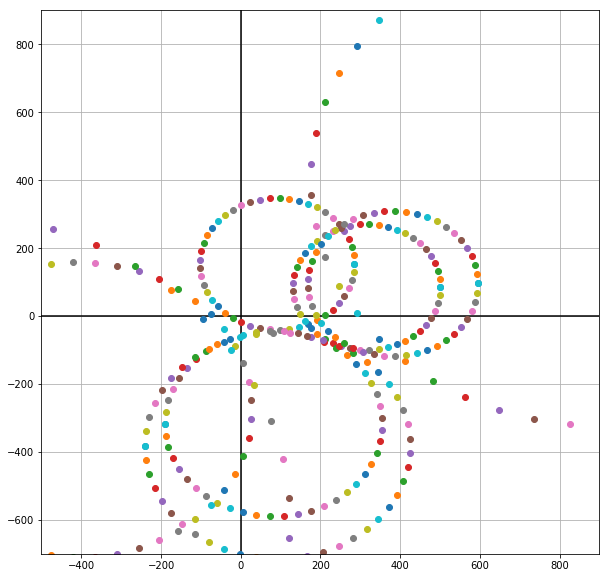

In [54]:
from math import cos, sin, sqrt, pi
lines = np.dstack((maxRhos, maxThetas))[0]

def circleFunction(x0, y0, r0, t):
    x = r0 * cos(t)
    y = r0 * sin(t)
    return x + x0, y + y0


plt.figure(figsize=(10,10))
ax = plt.axes()
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
#lim = 1500
ax.set_xlim(-500, 900)
ax.set_ylim(-700, 900)

for line in lines:
    rho = line[0]
    theta = line[1]
    #print(theta)
    #print(-cos(theta))
    #print(sin(theta))
    if rho == 0:
        continue
    if -cos(theta) / sin(theta) < -1:
        continue
    curve = (sin(theta) / (2 * rho)) * np.array([-cos(theta) / sin(theta), 1, sqrt((-cos(theta) / sin(theta)) + 1)])
    circleThetas = np.linspace(-pi, pi)
    yCircle = []
    for t in np.linspace(0, pi * 2):
        yCircle.append(circleFunction(curve[0], curve[1], curve[2], t))

    for circlePoint in yCircle:
        ax.plot(circlePoint[0], circlePoint[1], 'o')
plt.savefig("reconstruct.png")
plt.show()